# Spot detection for RNA imaging

Neubias course. May 14 th and may 15 th 2025. Pasteur Institute. 

Teacher: Jacques Bourg    
Helper:  Gaëlle Letort

In [1]:
import napari
import numpy as np
from skimage import io
from scipy.ndimage import gaussian_laplace, maximum_filter
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path

from Conv_explorer import ConvolutionExplorer
from detect_spots import DetectionPipeline
dt = DetectionPipeline()

from thresh_big_fish import SpotsThresholding

%load_ext autoreload
%autoreload 2

# I- Understanding the FISH signal. 

#### Nature of the signal and orders of magnitude

<div style="text-align: center;">
  <img src="misc/T2.png" alt="FISH imaging" width="1413" height="219">
</div>

#### What is a point spread function ? 

According to Wikipedia, the point spread function (PSF) describes the "response of a focused optical imaging system to a point source or point object".  
The image gatered though an optical imaging system results from the convolution of the real light source with the PSF. 

 
<div style="text-align: center;">
  <img src="misc/PSF.png" alt="FISH imaging" width="298" height="272">
</div>

Wikimedia Commons contributor.  Convolution illustrated: longitudinal (XZ) central slice of a 3D image acquired by a fluorescence microscope. [9 June 2006]. Wikimedia Commons, CC BY-SA 4.0.

For more details, read the full article.
https://en.wikipedia.org/wiki/Point_spread_function


In the next section we will go in detail in what a convolution is.

#### Signal exploration

Given the physical dimensions of the fluorophore (~ 2 nm) and that the spots that we observe in the next have a couple of pixels (each pixel in this image ~ 100 nm), what we observe is the PSF.

In the napari plugin you have two channels, the FISH channel (550 nm) and the DAPI channel (405 nm). You can change the Z and change the contrast to observe the FISH signal.

DAPI  is a fluorescent stain that binds strongly to adenine-thymine-rich regions in DNA, and therefore used as a nuclei marker.

In [2]:
im = io.imread(Path('./data/XPO-Im1-Cy3_MMStack_Pos0.ome.tif'))
viewer = napari.Viewer()
viewer.add_image(im);        # adjust the contrast

##  Algorithms for spot detection

####  a) Practical introduction to the convolution operation

<p align="center">
  <img src="misc/2D_Convolution_Animation.gif" alt="2D Convolution Animation" title="2D Convolution Animation">
</p>

Michael Plotke. (2013). 2D Convolution Animation. Wikimedia Commons. Retrieved 02/05/2025.

The convolution is an essential building block of several pattern recognition algorithms, among wich the two that we are going to refer in this notebook. This operation has several subtleties. We propose you to discover some of them by yourself by playing with the following tool. 

Look for instance at the :

- Influence of the kernel size.
- Apparition of artifacts.
- impact of the noise level on a posterior thresholding
- Selectivity of kernel when the kernel has a positive and negarive part (sum = 0)
- Superposition effects
- Effect of the inhibition
- Effect of the width of the inhibition
- Noise enhancement effect.
- False positives at high noise (if there was a threshold after the convolution).

Feel free to change the image.

In [3]:
image = np.zeros((100, 100))
image[20:40,20:40] = 1
image[60,20] = 7
image[80,20] = 2
l = 5
image[80-l:80+l+1,80] = 1
image[80,80-l:80+l+1] = 1
image[20-l:20+l+1,80] = 3
image[20,80-l:80+l+1] = 3
image[80,50]   = 3
image[80-3,50] = 3

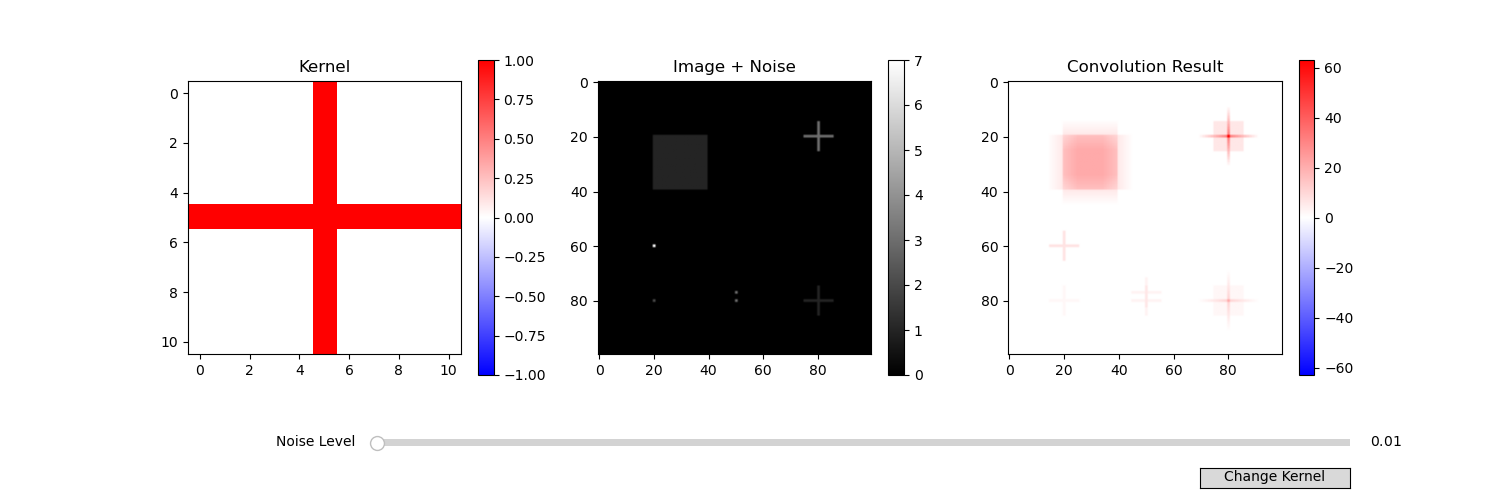

In [7]:
%matplotlib widget
explorer = ConvolutionExplorer(image,figsize=(15,5))    # reduce the image size if needed, for instance figsize=(10,5) 
explorer.show()

####  b) Traditional spot detection method: example of BIGFISH.

Big fish is an example of spot detection method developped by Florian Muller and colleagues, that employs classic computer vision techniques.

* Imbert, A., Ouyang, W., Safieddine, A., Coleno, E., Zimmer, C., Bertrand, E., Walter, T., & Mueller, F. (2022). FISH-quant v2: a scalable and modular tool for smFISH image analysis. RNA, 28(6), 786-795. http://www.rnajournal.org/cgi/pmidlookup?view=long&pmid=35347070


* Mueller, F., Senecal, A., Tantale, K., Marie-Nelly, H., Ly, N., Collin, O., Basyuk, E., Bertrand, E., Darzacq, X., & Zimmer, C. (2013). FISH-quant: automatic counting of transcripts in 3D FISH images. Nature Methods, 10(4), 277-278. https://doi.org/10.1038/nmeth.2406


In the next figure we describe the main steps of the algorithm, and we will visualize them afterwards on the data. The algorithm works on images or stack of images (2D or 3D tensors).

In this part we are going to go over the main computational steps of this algorithm. We will optimize by hand the crutial parameters. 

<div style="text-align: center;">
  <img src="misc/BigFISH_pipeline2.png" alt="FISH imaging" width="1413" height="210">
</div>

In [4]:
# lets look at the LoG kernel (2D version)

x     = np.linspace(-7, 7, 100)
y     = np.linspace(-7, 7, 100)
x, y  = np.meshgrid(x, y)
sigma = 2.0
LoG_kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))*(1- (x**2 + y**2)/(2 * sigma**2))*(-1/(np.pi * sigma **4))

fig = go.Figure(data=[go.Surface(z=LoG_kernel, x=x, y=y)])
fig.update_layout(title='Laplacian of Gaussian (LoG) Kernel', scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='LoG Value'))
fig.show()

In [5]:
im_fish = im[0,...]
im_2d   = np.max(im_fish, axis=0)     # we project onto 2d only for visualization purposes

Go over the code and identify the main computational steps described in the pipeline.

Step 1:  optimize the LoG

* Find the right spatial scale to enhance the signal of the dots. Choose a float in the range  [.1, .6]. Observe the introduction of artifacts

In [6]:
sigma   = .5               #   choose a float in the range  [0.2, 0.6]               
im_LoG  = gaussian_laplace(im_2d, sigma=sigma)
im_rect = np.clip(-im_LoG, a_min=0, a_max=None)

viewer_1 = napari.Viewer()
viewer_1.add_image(im_2d, contrast_limits=(0, np.percentile(im_2d, 99.9)), name='2D projection of image', opacity=1.0);
viewer_1.add_image(im_rect, contrast_limits=(0, np.percentile(im_rect, 99.9)), name='rectified image', opacity=1.0);

Step 2:  optimize the local max scale.

  Find the adecuate distance between peaks, choose an int in the range  [1, 15]

In [7]:
# local max detection     
min_distance = 5                              #   choose an integer in the range  [1, 20]                                            
kernel_size  = 2 * np.ceil((min_distance,) * im_rect.ndim).astype(im_rect.dtype) + 1
im_max_filt  = maximum_filter(im_rect, size=kernel_size)                            
mask0        = im_rect == im_max_filt         # A pixel which has the same value in the original and filtered images is a local maximum.

viewer_2 = napari.Viewer()
viewer_2.add_image(im_2d, contrast_limits=(0, np.percentile(im_2d, 99.9)), name='2D projection of image', opacity=1.0);
viewer_2.add_image(im_rect, contrast_limits=(0, np.percentile(im_rect, 99.9)), name='rectified image', opacity=1.0);

viewer_2.add_image(im_max_filt, contrast_limits=(0, np.percentile(im_max_filt, 97)), name='maximum filter', opacity=1.0);
viewer_2.add_labels(mask0, name='candidate threshold per neighboorhood');

Step 3:  take into account the intensity for thresholding

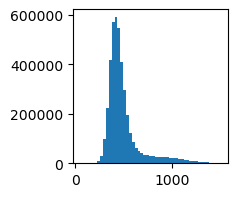

In [8]:
fig, ax = plt.subplots(figsize=(2,2))
ax.hist(im_rect.flatten(), bins=np.linspace(50,1500));

Comment the figure above.

In [9]:
# thresholding and peak coordinates
threshold    = 1300     # optimize the threshold (set a value between 700 and 1300)
mask1        = (mask0 & (im_rect > threshold))
spots        = np.column_stack(np.nonzero(mask1))

viewer_bf = napari.Viewer()
viewer_bf.add_image(im_2d, contrast_limits=(0, np.percentile(im_2d, 99.9)), name='2D projection of image', opacity=1.0);
viewer_bf.add_image(-im_LoG, contrast_limits=(0, np.percentile(-im_LoG, 99.9)), name='Convoluted image by LoG kernel', opacity=1.0);
viewer_bf.add_image(im_max_filt, contrast_limits=(0, np.percentile(im_max_filt, 97)), name='Im max filtered', opacity=1.0);
viewer_bf.add_labels(mask0, name='candidate threshold per neighboorhood');
viewer_bf.add_points(spots, size=3, name= 'spots', border_color='green', face_color=[0, 0, 0, 0]);

In [10]:
io.imsave( "fish_image.tif", im_2d)  # save the fish image in a single file

/home/jacques/miniconda3/envs/spot_course_env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning:

fish_image.tif is a low contrast image



We are now going to optimize again in a more interactive way the threshold and obtain all the spots location.

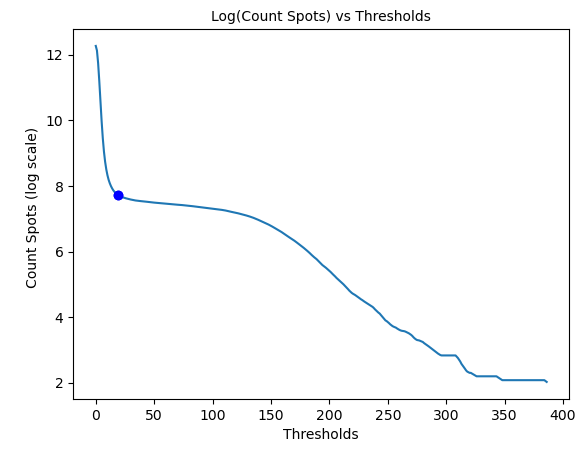

In [12]:
st = SpotsThresholding(BATCH=[Path('./fish_image.tif')], subtract_fish=False, voxel_size_nm=(103,103), object_radius_nm=(150, 150))
st.run();

* What about false positives ? Can we get read of them by carefully choosing the threshold ? 

* Look at the bottom left of the figure. What do tou think about the found dots ? Can you think of a biological situation in which this method might show its limits ? 

#### Signal quality

The SNR is defined as:

<div style="text-align: center;">
  <img src="misc/snr_def.png" alt="FISH imaging" width="250" height="53">
</div>


where std stands for standard deviation.

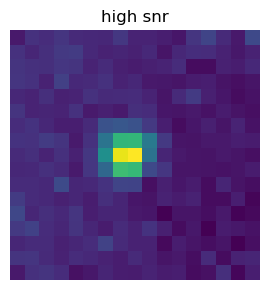

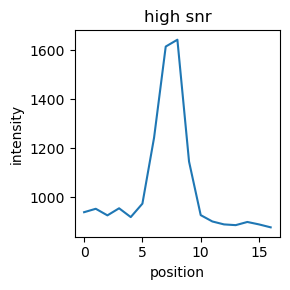

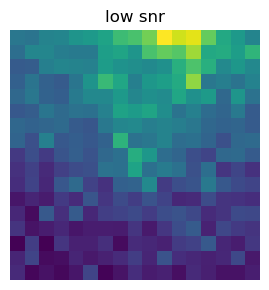

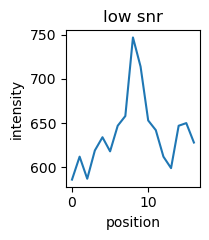

In [13]:
spot  = [1185, 1112]
window= 8 

fig, ax = plt.subplots(figsize=(3, 3))
sub_im = im_2d[spot[0]-window : spot[0]+window+1, spot[1]-window:spot[1]+window+1]
ax.imshow(sub_im, vmin= sub_im.min(), vmax = sub_im.max());
ax.set_title('high snr');
ax.set_axis_off()
fig.tight_layout()

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(im_2d[spot[0], spot[1]-window:spot[1]+window+1]);
ax.set_xlabel('position');
ax.set_ylabel('intensity');
ax.set_title('high snr');
fig.tight_layout()

spot  = [1587, 1675]
window= 8 

fig, ax = plt.subplots(figsize=(3, 3))
sub_im  = im_2d[spot[0]-window : spot[0]+window+1, spot[1]-window:spot[1]+window+1]
ax.imshow(sub_im, vmin= sub_im.min(), vmax = sub_im.max());
ax.set_title('low snr');
ax.set_axis_off()
fig.tight_layout()

fig, ax = plt.subplots(figsize=(2.2,2.5))
ax.plot(im_2d[spot[0], spot[1]-window:spot[1]+window+1]);
ax.set_xlabel('position');
ax.set_ylabel('intensity');
ax.set_title('low snr');
fig.tight_layout()

Understand the definition of the SNR looking at the plots.

In [14]:
spots_bf = st.detected_spots['fish_image']

#### Recap exercice (advanced, skip if necessary)
 
   You have two new images A and B.
   
   Using the SpotsThresholding class threshold semi-manually the spots.

   Determine how much spots there are in each image. 
      
   Use the big fish documentation to compute the mean snr (averaged across spots) in each image and determine which image has better SNR.

   https://big-fish.readthedocs.io/en/stable/detection/spots.html#bigfish.detection.compute_snr_spots

   In the previous examples, we used spot detection on 2D images (max intensity projections of a stack of images). However it is way better to 
   do the spot detection in 3D. Feel free in this exercice to rather do the spot detection in 3D. 

   Explicit the reasons on why it is better to do 3D instead of 2D.

Can you come up with a biological explanation of why one image would have a better SNR than the other ?

## Comparing semi manual and fully automated methods.

In here we will present a fully automated method called UFISH.

<div style="text-align: center;">
  <img src="misc/UFISH.png" alt="FISH imaging" width="1000" height="642">
</div>


This autoencoder (U-Net) network is based on the seminal U-Net architecture, which is the based for several state of the art algorithms on different 
domains like image segmentation a (Cellpose is based on it), image denoising and diffusion models. U-Net themselves are a special type of convolutional 
neural network (CNN). CNNs are composed layers with learnable filters (kernels), to automatically detect hierarchical patterns and features within the input data. These filters can the input, identifying simple features like edges and corners in early layers, and progressively more complex structures in deeper layers.


https://en.wikipedia.org/wiki/Convolutional_neural_network


Xu, W., Cai, H., Zhang, Q., Mueller, F., Ouyang, W., & Cao, G. (2024). U-FISH: a universal deep learning approach
for accurate FISH spot detection across diverse datasets. bioRxiv, 2024.03.06.583706. https://doi.org/10.1101/2024.03.06.583706

Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks for biomed-
ical image segmentation. In Medical Image Computing and Computer-Assisted Intervention–
MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceed-
ings, Part III 18, pages 234–241. Springer, 2015.



Why using an automated method ? 
   
    * For reproductibility.
    * For potential improved accuracy. These models might consider several more variables in the decision (spot vs no spot) than just the intensity (as the case of big fish).

    As we will see they might also have their limitations. 

In [20]:
file_data   = str(Path('./fish_image.tif'));
target_dir  = str(Path('./spots_uf.npy'));

spots_uf1   = dt.spot_ufish(file_data, target_dir);

CompletedProcess(args=['bash', 'env_activate_ufish_v2.sh', 'fish_image.tif', 'spots_uf.npy', PosixPath('.')], returncode=0, stdout='Python result: \n', stderr="2025-05-09 13:31:09.704 | INFO     | ufish.api:init_model:70 - Initializing ufish model with kwargs: {}\n2025-05-09 13:31:09.704 | INFO     | ufish.api:init_model:72 - Number of parameters: 162959\n2025-05-09 13:31:09.854 | INFO     | ufish.api:init_model:78 - CUDA is available, using GPU.\n2025-05-09 13:31:09.854 | INFO     | ufish.api:_load_pth_file:232 - Loading weights from /home/jacques/Documents/FISH/course_neubias/Course_on_git/Pasteur-BioImage-Analysis-Course-2025/Analyst/Day3/Spot_detection_for_RNA_imaging/v1.0-alldata-ufish_c32.pth\n/home/jacques/miniconda3/envs/ufish_env/lib/python3.10/site-packages/ufish/api.py:234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which wi

In [22]:
viewer_3 = napari.Viewer()
viewer_3.add_image(im_2d, contrast_limits=(0, np.percentile(im_2d, 99.9)), name='2D projection of image', opacity=1.0);
viewer_3.add_points(spots_uf1, name="spots ufish", face_color=[0, 0, 0, 0],  border_color='#0000FF', size=4);
viewer_3.add_points(spots_bf, name="spots bigfish", face_color="red",  size=2);

Conclusion ?

In [19]:
file_data   = str(Path('./data/C.tiff'))
target_dir  = str(Path('./spots_uf.npy'))
spots_uf2   = dt.spot_ufish(file_data, target_dir)

CompletedProcess(args=['bash', 'env_activate_ufish_v2.sh', 'data/C.tiff', 'spots_uf.npy', PosixPath('.')], returncode=0, stdout='Python result: \n', stderr="2025-05-09 13:30:55.141 | INFO     | ufish.api:init_model:70 - Initializing ufish model with kwargs: {}\n2025-05-09 13:30:55.141 | INFO     | ufish.api:init_model:72 - Number of parameters: 162959\n2025-05-09 13:30:55.303 | INFO     | ufish.api:init_model:78 - CUDA is available, using GPU.\n2025-05-09 13:30:55.303 | INFO     | ufish.api:_load_pth_file:232 - Loading weights from /home/jacques/Documents/FISH/course_neubias/Course_on_git/Pasteur-BioImage-Analysis-Course-2025/Analyst/Day3/Spot_detection_for_RNA_imaging/v1.0-alldata-ufish_c32.pth\n/home/jacques/miniconda3/envs/ufish_env/lib/python3.10/site-packages/ufish/api.py:234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will 

Lets consider another example:

In [23]:
im_C     = io.imread(Path("./data/C.tiff"))
mpi_C    = im_C.copy()

viewer_4 = napari.Viewer()
viewer_4.add_image(mpi_C, contrast_limits=(0, np.percentile(mpi_C, 99.9)), name='2D projection of image', opacity=1.0);
viewer_4.add_points(spots_uf2[:,:], name="spots ufish", face_color=[0, 0, 0, 0],  border_color='#0000FF', size=4);

Conclusion ?

Discuss the following table and discuss if it is uncomplete.


| Feature          | Totally Automatic (U-FISH)                      | Semi-Manual (Big-FISH approaches)             |
| :--------------- | :---------------------------------------------- | :-------------------------------------------- |
| User Interaction | Minimal to none after training                  | Significant for parameter tuning and validation |
| Methodology      | Deep Learning (U-Net)                           | Traditional Image Processing (filtering, peak detection, thresholding) |
| Training Data    | Requires large, diverse dataset for training    | Less dependent on large pre-annotated data    |
| Parameter Tuning | Largely eliminated                              | Often required and dataset-specific           |
| Reproducibility  | High (given the same model)                     | Can be lower due to manual steps              |
| Generalizability | High across diverse datasets (if well-trained)  | Can be challenging across diverse datasets    |
| Computational    | High for training, moderate for inference       | Moderate for detection                        |
| Interpretability | Lower                                           | Higher                                        |
| Throughput       | High                                            | Lower (due to manual steps)                   |

Follow up:

It is possible to retrain your ufish model.
For a tutorial, follow this notebook: https://github.com/UFISH-Team/U-FISH/blob/main/notebooks/ufish_finetune.ipynb


In [105]:
sigma   = 0.5
min_distance = 10
threshold    = 1300